## 0. Imports + load Data

In [1]:
## Imports

### Math
import numpy as np

### sklearn
#### Transformation
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#### Models
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn import svm
#### Model Optim
from sklearn.model_selection import GridSearchCV
#### Evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
#### Autre
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Viz
import  matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### Autres
from scipy.stats import mode
from time import time

## Datas
from sklearn.datasets import load_digits
digits = load_digits()

# Show dimensionality
print(digits.data.shape)
print(digits.images.shape)

(1797, 64)
(1797, 8, 8)


Notre dataset se composent de 1797 échantillons avec 64 caractéristiques, où chacune des 64 caractéristiques est la luminosité d'un pixel dans une image 8 × 8

## 1. Fit cluster on digit datas

In [2]:
kmeans = KMeans(init="k-means++", n_clusters=10, random_state=0, n_init=4) # init="k-means++"
clusters = kmeans.fit_predict(digits.data)
print('Les centroides ont pour dimension', kmeans.cluster_centers_.shape)
kmeans.labels_[:5]

Les centroides ont pour dimension (10, 64)


array([4, 7, 7, 3, 6], dtype=int32)

Il s'agit de dix images de 64 pixels. **Nous alons les visualiser**

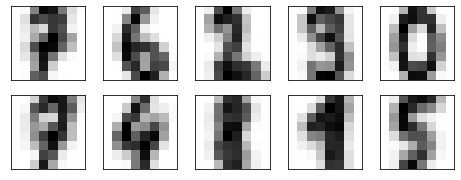

In [3]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)


On remarque que les 10 clusteur on bel et bien comme centroïde les 10 chiffres -> **C'est déjà une bonne nouvelle**. Même sans étiquette l'algorithme Kmeans est capable de retrouver les 10 images différentes. On peux déjà remarquer que l'image 8 choisie comme centroïde est très peux reconnaisable, on a surement des erreur quand au clustering de ce type d'images.

## 2. Performances evaluations

### 2.1. With metrics of Superfised Classification

On ne peux pas utiliser directement les labels données par kmeans car les clusters sont numérotés de manière arbitraires.

In [4]:
labels_pred = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels_pred[mask] = mode(digits.target[mask])[0]

In [5]:
## Accuracy score
acc_score_clust = accuracy_score(digits.target, labels_pred)
prec_clust = round(precision_score(list(digits.target), list(labels_pred), average = 'macro'),3)*100
recall_clust = round(recall_score(digits.target, labels_pred, average = 'macro'),3)*100

print("")
print("Accuracy score {} %".format(acc_score_clust.round(3)*100))
print("La précision obtenue est de {} %".format(prec_clust))
print("Le recall obtenue est de {} %".format(recall_clust))
print(classification_report(digits.target, labels_pred))


Accuracy score 73.0 %
La précision obtenue est de 70.19999999999999 %
Le recall obtenue est de 73.0 %
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       178
           1       0.62      0.30      0.41       182
           2       0.83      0.85      0.84       177
           3       0.41      0.90      0.56       183
           4       0.99      0.91      0.95       181
           5       0.93      0.77      0.84       182
           6       0.97      0.98      0.97       181
           7       0.82      1.00      0.90       179
           8       0.46      0.60      0.52       174
           9       0.00      0.00      0.00       180

    accuracy                           0.73      1797
   macro avg       0.70      0.73      0.70      1797
weighted avg       0.70      0.73      0.70      1797



/home/anthony/anaconda3/envs/plotly/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anthony/anaconda3/envs/plotly/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


A priori le clustering est bien réalisé sur certaines classe comme 0, 4, 6 mais bien moins sur le 8 par exemple. 

Visualison la matrice de confusion pour avoir une vision plus fine

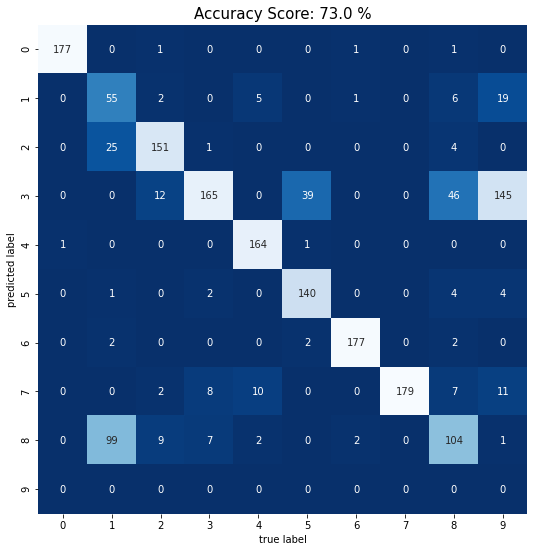

In [6]:
conf_mat_clust = confusion_matrix(digits.target, labels_pred)
fif = plt.figure(figsize=(9,9))
sns.heatmap(conf_mat_clust.T, square=True, annot=True, fmt='d', cbar=False,
            cmap = 'Blues_r',
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');
all_sample_title = 'Accuracy Score: {0} %'.format(round(acc_score_clust,3)*100)
plt.title(all_sample_title, size = 15);

Comme on l'imaginait les images labelisées 8 sont confondus avec les 1.

### 2.1. With Unsuperfised Classification

Reconstruction des étiquettes

In [20]:

def bench_k_means(kmeans, name, data, labels, use_stadard_scaler):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    if use_stadard_scaler:
        estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    else:
        estimator = make_pipeline(kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
        metrics.normalized_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(data, estimator[-1].labels_,
                                 metric="euclidean", sample_size=300,)
    ]

    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [31]:
use_st_sc = True
for i in range(2):
    print("standard scaler :", use_st_sc)
    print(82 * '_')
    print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tNMI\tsilhouette')

    ## Random init
    kmeans = KMeans(init="random", n_clusters=10, n_init=4, random_state=0)
    bench_k_means(kmeans=kmeans, name="random", data=digits.data, labels=digits.target, use_stadard_scaler=use_st_sc)

    ## k-means++ init
    kmeans = KMeans(init="k-means++", n_clusters=10, n_init=4,
                    random_state=0)
    bench_k_means(kmeans=kmeans, name="k-means++", data=digits.data, labels=digits.target, use_stadard_scaler=use_st_sc)

    ## PCA components init
    pca = PCA(n_components=10).fit(digits.data)
    kmeans = KMeans(init=pca.components_, n_clusters=10, n_init=1)
    bench_k_means(kmeans=kmeans, name="PCA-based", data=digits.data, labels=digits.target, use_stadard_scaler=use_st_sc)

    print(82 * '_')
    print('')
    print('')
    use_st_sc = False
    
print('homo : homogeneity_score, compl : completeness_score, v-meas : v-measurment, ARI : adjusted_rand_score, AMI : adjusted_mutual_info_score, NMI : normalized_mutual_info_score')

standard scaler : True
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	NMI	silhouette
random   	0.124s	69952	0.545	0.616	0.578	0.415	0.574	0.578	0.136
k-means++	0.218s	69485	0.613	0.660	0.636	0.482	0.632	0.636	0.172
PCA-based	0.058s	72686	0.636	0.658	0.647	0.521	0.643	0.647	0.149
__________________________________________________________________________________


standard scaler : False
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	NMI	silhouette
random   	0.166s	1166041	0.734	0.741	0.738	0.657	0.735	0.738	0.172
k-means++	0.114s	1169656	0.702	0.733	0.717	0.578	0.714	0.717	0.186
PCA-based	0.090s	1188310	0.784	0.787	0.785	0.741	0.783	0.785	0.176
__________________________________________________________________________________


homo : homogeneity_score, compl : completeness_score, v-meas : v-measurment, ARI : adjusted_rand_scor

L'utilisation de standard scaler dans notre cas pour standardiser les données en entrée diminue les performances.

## 3. Improve Kmeans with PCA components initializis

Dans un premier temps nous allons rédure le nombre de dimension et estimer l'impact sur le clustering

In [35]:
pca = PCA(n_components=10)
digits_proj_PCA = pca.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj_PCA)

# Permute the labels
labels_pred_optim = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels_pred_optim[mask] = mode(digits.target[mask])[0]

## Accuracy score
acc_score_clust_optim = accuracy_score(digits.target, labels_pred_optim)
prec_clust_optim = round(precision_score(list(digits.target), list(labels_pred_optim), average = 'macro'),3)*100
recall_clust_optim = round(recall_score(digits.target, labels_pred_optim, average = 'macro'),3)*100

print("")
print("Accuracy score {} %".format(acc_score_clust_optim.round(3)*100))
print("La précision obtenue est de {} %".format(prec_clust_optim))
print("Le recall obtenue est de {} %".format(recall_clust_optim))
print(classification_report(digits.target, labels_pred_optim))



Accuracy score 78.60000000000001 %
La précision obtenue est de 73.8 %
Le recall obtenue est de 78.4 %
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       178
           1       0.50      0.85      0.63       182
           2       0.84      0.85      0.85       177
           3       0.87      0.83      0.85       183
           4       0.96      0.91      0.93       181
           5       0.84      0.75      0.79       182
           6       0.97      0.97      0.97       181
           7       0.83      0.93      0.88       179
           8       0.00      0.00      0.00       174
           9       0.56      0.77      0.65       180

    accuracy                           0.79      1797
   macro avg       0.74      0.78      0.75      1797
weighted avg       0.74      0.79      0.76      1797



/home/anthony/anaconda3/envs/plotly/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anthony/anaconda3/envs/plotly/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Comme on pouvait s'y attendre la PCA nous fais perdre de l'information (lorsqu'on utilise un petit nombre de composante) en réduisant le nombre de features, en revanche on utilisera la PCA avec 2 composantes pour visualiser les clusters ( cf part 4).

A partir de 10 composantes on commence à augmenter les performances.

Il est possible d'améliorer les résultats plus significativement en utilisant les composantes principales pour initier les centroïdes du Kmeans

In [10]:
pca = PCA(n_components=10).fit(digits.data)
kmeans = KMeans(init=pca.components_, n_clusters=10, n_init=1)
clusters = kmeans.fit_predict(digits.data)

# Permute the labels
labels_pred_optim = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels_pred_optim[mask] = mode(digits.target[mask])[0]

## Accuracy score
acc_score_clust_optim = accuracy_score(digits.target, labels_pred_optim)
prec_clust_optim = round(precision_score(list(digits.target), list(labels_pred_optim), average = 'macro'),3)*100
recall_clust_optim = round(recall_score(digits.target, labels_pred_optim, average = 'macro'),3)*100

print("")
print("Accuracy score {} %".format(acc_score_clust_optim.round(3)*100))
print("La précision obtenue est de {} %".format(prec_clust_optim))
print("Le recall obtenue est de {} %".format(recall_clust_optim))
print(classification_report(digits.target, labels_pred_optim))

print('AMI avec scipy mode:', metrics.adjusted_mutual_info_score(digits.target, labels_pred_optim))
print('NMI avec scipy mode:', metrics.normalized_mutual_info_score(digits.target, labels_pred_optim))

print('AMI sans scipy mode:', metrics.adjusted_mutual_info_score(digits.target, kmeans.labels_))
print('NMI sans scipy mode:', metrics.normalized_mutual_info_score(digits.target, kmeans.labels_))



Accuracy score 87.0 %
La précision obtenue est de 87.8 %
Le recall obtenue est de 87.0 %
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       178
           1       0.83      0.71      0.77       182
           2       0.84      0.82      0.83       177
           3       0.92      0.87      0.89       183
           4       0.96      0.91      0.93       181
           5       0.88      0.75      0.81       182
           6       0.97      0.97      0.97       181
           7       0.86      0.97      0.91       179
           8       0.87      0.82      0.84       174
           9       0.66      0.89      0.75       180

    accuracy                           0.87      1797
   macro avg       0.88      0.87      0.87      1797
weighted avg       0.88      0.87      0.87      1797

AMI avec scipy mode: 0.7832960490985799
NMI avec scipy mode: 0.7854468235210125
AMI sans scipy mode: 0.78329604909858
NMI sans scipy mode: 0.7854468235

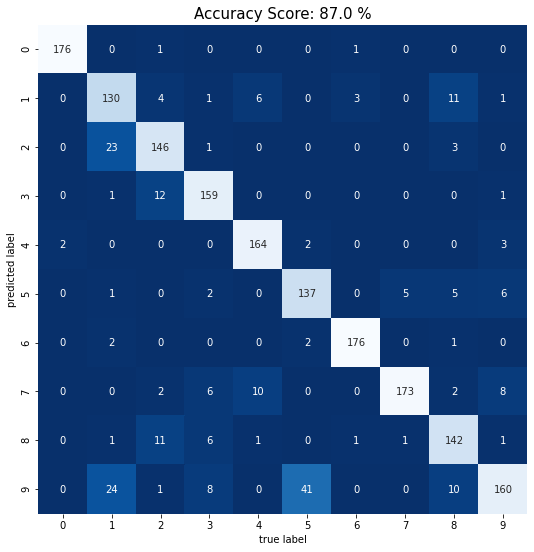

In [11]:
conf_mat_clust_optim = confusion_matrix(digits.target, labels_pred_optim)
fig2 = plt.figure(figsize=(9,9))
sns.heatmap(conf_mat_clust_optim.T, square=True, annot=True, fmt='d', cbar=False,
            cmap = 'Blues_r',
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');
all_sample_title = 'Accuracy Score: {0} %'.format(round(acc_score_clust_optim,3)*100)
plt.title(all_sample_title, size = 15);

### TSNE
L'algorithme t-SNE (t-distributed stochastic neighbor embedding) est une technique de réduction de dimension pour la visualisation de données développée par Geoffrey Hinton et Laurens van der Maaten. Il s'agit d'une méthode non linéaire permettant de représenter un ensemble de points d'un espace à grande dimension dans un espace de deux ou trois dimensions, les données peuvent ensuite être visualisées avec un nuage de points. L'algorithme t-SNE tente de trouver une configuration optimale selon un critère de théorie de l'information pour respecter les proximités entre points : deux points qui sont proches (resp. éloignés) dans l'espace d'origine devront être proches (resp. éloignés) dans l'espace de faible dimension. 
L'algorithme t-SNE consiste à faire concorder les deux densités de probabilité, en minimisant la divergence de Kullback-Leibler entre les deux distributions par rapport à l'emplacement des points sur la carte. 

In [12]:
# Project the data
tsne = TSNE(n_components=2, init='random', random_state=42)
digits_proj = tsne.fit_transform(digits.data)


# Compute the clusters
kmeans = KMeans(init="k-means++", n_clusters=10, random_state=0, n_init=4)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels_pred_optim = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels_pred_optim[mask] = mode(digits.target[mask])[0]

## Accuracy score
acc_score_clust_optim = accuracy_score(digits.target, labels_pred_optim)
prec_clust_optim = round(precision_score(list(digits.target), list(labels_pred_optim), average = 'macro'),3)*100
recall_clust_optim = round(recall_score(digits.target, labels_pred_optim, average = 'macro'),3)*100

print("")
print("Accuracy score {} %".format(acc_score_clust_optim.round(3)*100))
print("La précision obtenue est de {} %".format(prec_clust_optim))
print("Le recall obtenue est de {} %".format(recall_clust_optim))
print(classification_report(digits.target, labels_pred_optim))



Accuracy score 94.39999999999999 %
La précision obtenue est de 94.69999999999999 %
Le recall obtenue est de 94.5 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       0.86      0.85      0.86       182
           2       0.86      0.94      0.90       177
           3       0.99      0.92      0.95       183
           4       1.00      0.98      0.99       181
           5       0.98      0.99      0.98       182
           6       0.99      1.00      1.00       181
           7       0.94      1.00      0.97       179
           8       0.86      0.97      0.91       174
           9       0.99      0.79      0.88       180

    accuracy                           0.94      1797
   macro avg       0.95      0.94      0.94      1797
weighted avg       0.95      0.94      0.94      1797



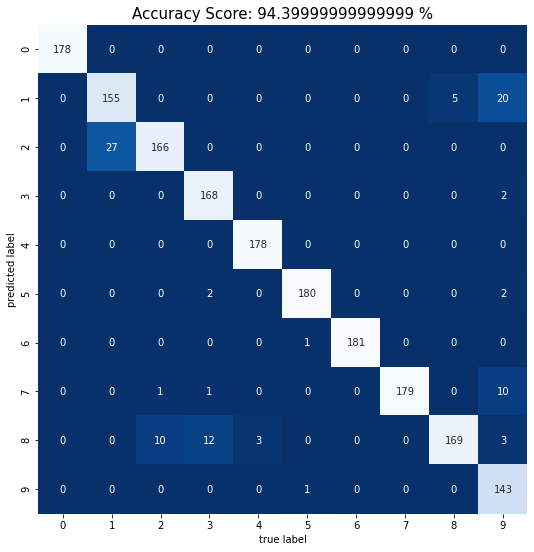

In [13]:
conf_mat_clust_optim = confusion_matrix(digits.target, labels_pred_optim)
fig2 = plt.figure(figsize=(9,9))
sns.heatmap(conf_mat_clust_optim.T, square=True, annot=True, fmt='d', cbar=False,
            cmap = 'Blues_r',
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');
all_sample_title = 'Accuracy Score: {0} %'.format(round(acc_score_clust_optim,3)*100)
plt.title(all_sample_title, size = 15);

On obtient quand même presque 95% de bonnes prédiction sans connaitre les label au départ !!

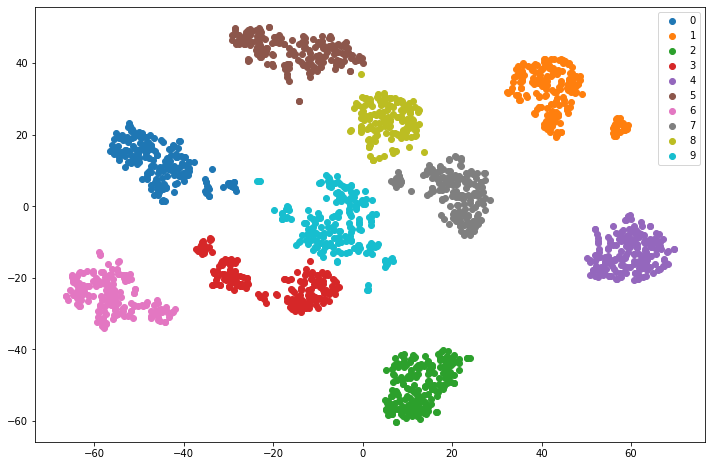

In [14]:
fig3 = plt.figure(figsize =(12,8))

for i in np.unique(labels_pred_optim):
    plt.scatter(digits_proj[clusters==i, 0], digits_proj[clusters==i, 1], label=i)
plt.legend()
plt.show()


## 4. Visualize Custers using PCA

In [ ]:
pca = PCA(n_components=10).fit(digits.data)
reduced_data = PCA(n_components=2).fit_transform(digits.data)
print('variance PCA en fonction du nombre de composante : ', pca.explained_variance_ratio_.cumsum())
print('On peux déjà conclure que le graphique en 2D utilisant la PCA ne sera pas très représentatif car')
print('si on ne considère que deux composante on tient compte que de 28% de la variance totale')
kmeans = KMeans(init="k-means++", n_clusters=10, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="w", zorder=10)
plt.title("K-means clustering on the digits dataset (PCA-reduced data)\n"
          "Centroids are marked with white cross")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


## 5. Comparaison avec les algorithmes de classivication supervisés

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(digits.data, digits.target, test_size=0.2, random_state=0)

SVM = svm.SVC()

## Fit + predict
%timeit SVM.fit(xtrain, ytrain)
SVM.fit(xtrain, ytrain)

ypredSVM = SVM.predict(xtest)

In [ ]:
print('----------------------SVM---------------------------')
print(classification_report(ytest, ypredSVM))

Le modèle SVM est plus performant -> f1_score 99% mais tous de même sans les labels on obtient 94% avec Kmeans.
Dans les deux cas les modèles ne sont pas optimisés au max mais tout de même.